### Training Burgers

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

# def max_min_normalize():
#     assert Traj_dataset.traj_train is not None
#     max_val = Traj_dataset.traj_train[:32].max()
#     min_val = Traj_dataset.traj_train[:32].min()
#     mean = (max_val + min_val) / 2
#     std = (max_val - min_val) / 2
#     print(f'Max: {max_val}, Min: {min_val}')
#     Traj_dataset.mean = mean
#     Traj_dataset.std = std


hydra.initialize(config_path="cfg_flexible", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=KdV", "nt=14"])


print('Loading training data...')
with h5py.File(cfg.dataset.train_path, 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde'][:1000, :131], dtype=torch.float32)
print('Loading test data...')
with h5py.File(cfg.dataset.test_path, 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde'][:1000, :131], dtype=torch.float32)

# print(Traj_dataset.traj_train.mean(dim=-1))

# if cfg.equation == 'Heat' or cfg.equation == 'KS':
#     max_min_normalize()
# else:

mean_std_normalize()

Loading training data...
Loading test data...
Mean: -2.8792795925269843e-10, Std: 0.6221612691879272


In [10]:
import h5py
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

import argparse
import time

from eval_utils import compute_metrics
from utils import set_seed, flatten_configdict, trajectory_model, direct_model, split_model, normalized_model, zero_mean_model, normalized_residual_model

unrolling = cfg.train.unrolling
nt = cfg.nt
ensemble_size = 2
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = cfg.initial_datasize

loss_hist = []

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=tuple(cfg.model.n_modes), hidden_channels=64,
                in_channels=1, out_channels=1)
    model = model.to(device)
    
    # model=normalized_model(model, Traj_dataset.mean, Traj_dataset.std, Traj_dataset.mean, Traj_dataset.std)
    model=normalized_residual_model(model, Traj_dataset.mean, Traj_dataset.std)
    # model = zero_mean_model(normalized_model(model, Traj_dataset.mean, Traj_dataset.std, Traj_dataset.mean, Traj_dataset.std))
    # model = zero_mean_model(normalized_residual_model(model, Traj_dataset.mean, Traj_dataset.std))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.squeeze(1), y.squeeze(1)
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        loss_hist.append(total_loss)

        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

datasize=32
timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
Y = Traj_dataset.traj_train[:,0::timestep]
train_nts = torch.zeros(Y.shape[0], device=device).int()
train_nts[:datasize] = nt
# model = train(Y, train_nts)
ensemble = [train(Y, train_nts) for _ in range(ensemble_size)]


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


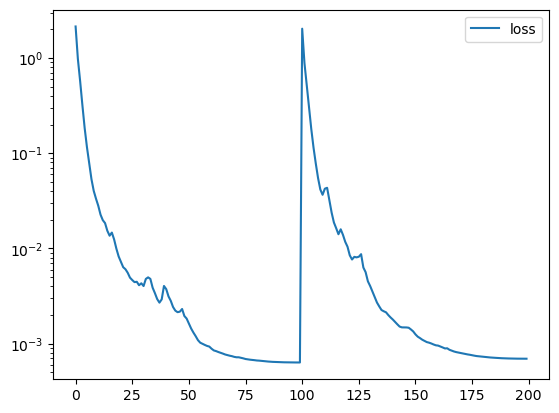

In [11]:
# log scale
plt.figure()
plt.plot(loss_hist, label='loss')
plt.yscale('log')
plt.legend()

In [27]:
import torch
from tqdm import tqdm
from utils import direct_model, trajectory_model, split_model, torch_delete, torch_expand
import numpy as np
from acquisition.acquisition_function import EER_Calculator

L = cfg.nt-1

X = Y[80:81, 0]
S = torch.ones(1,L).bool()
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
score = a(S) / S.sum()

print(S)
print(score)

for i in range(100):
    S_new = S.clone()
    change = torch.bernoulli(torch.ones(1,L) * 0.1).bool()
    S_new = S_new ^ change
    new_score = a(S_new) / S_new.sum()
    if new_score > score:
        S = S_new
        score = new_score
    print(S_new.sum())
    print(S_new)
    print(new_score)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]])
tensor([3.4603], device='cuda:0')
tensor(13)
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]])
tensor([3.4603], device='cuda:0')
tensor(8)
tensor([[ True, False,  True, False,  True,  True,  True,  True,  True, False,
         False,  True, False]])
tensor([4.3839], device='cuda:0')
tensor(7)
tensor([[False, False,  True, False,  True,  True,  True,  True,  True, False,
         False,  True, False]])
tensor([4.9431], device='cuda:0')
tensor(6)
tensor([[False, False,  True,  True,  True, False,  True,  True,  True, False,
         False, False, False]])
tensor([5.8685], device='cuda:0')
tensor(8)
tensor([[False,  True,  True,  True,  True, False,  True,  True,  True, False,
         False,  True, False]])
tensor([4.5131], device='cuda:0')
tensor(6)
tensor([[False, False,  True,  True,  True, False,  True,  True,  True, False,
         False, 

In [21]:
S = torch.zeros(1,L).bool()
S[0,0:5]=True
print(S)
print(a(S) / S.sum())


tensor([[ True,  True,  True,  True,  True, False, False, False, False, False,
         False, False, False]])
tensor([7.2341], device='cuda:0')


In [16]:
import torch
from tqdm import tqdm
from utils import direct_model, trajectory_model, split_model, torch_delete, torch_expand
import numpy as np
from acquisition.acquisition_function import EER_Calculator

L = cfg.nt-1

X = Y[80:81, 0]
S = torch.ones(1,L).bool()
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
score = a(S) / S.sum()

print(S)
print(score)

for i in range(100):
    S_new = S.clone()
    change = torch.bernoulli(torch.ones(1,L) * 0.1).bool()
    S_new = S_new ^ change
    new_score = a(S_new) / S_new.sum()
    if torch.rand(1) < min(1, (new_score / score).cpu()):
        S = S_new
        score = new_score
    print(S_new.sum())
    print(S_new)
    print(new_score)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]])
tensor([3.4603], device='cuda:0')
tensor(9)
tensor([[False, False,  True,  True, False,  True, False,  True,  True,  True,
          True,  True,  True]])
tensor([3.5455], device='cuda:0')
tensor(8)
tensor([[False, False, False,  True, False,  True, False,  True,  True,  True,
          True,  True,  True]])
tensor([2.9899], device='cuda:0')
tensor(7)
tensor([[False, False,  True,  True, False,  True, False,  True, False,  True,
         False,  True,  True]])
tensor([4.3320], device='cuda:0')
tensor(6)
tensor([[False, False,  True,  True, False,  True, False,  True, False,  True,
         False, False,  True]])
tensor([4.9564], device='cuda:0')
tensor(5)
tensor([[False, False,  True, False, False,  True, False,  True, False,  True,
         False, False,  True]])
tensor([4.1029], device='cuda:0')
tensor(4)
tensor([[False, False,  True, False, False,  True, False, False, False,  True,
    

In [22]:
import torch
from tqdm import tqdm
from utils import direct_model, trajectory_model, split_model, torch_delete, torch_expand
import numpy as np
from acquisition.acquisition_function import EER_Calculator

L = cfg.nt-1

X = Y[80:81, 0]
S = torch.ones(1,L).bool()
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
score = a(S) / S.sum()

print(S)
print(score)

for i in range(100):
    S_new = S.clone()
    change = torch.bernoulli(torch.ones(1,L) * 0.1).bool()
    S_new = S_new ^ change
    new_score = a(S_new) / S_new.sum()
    if torch.rand(1) < min(1, (new_score / score).cpu()):
        S = S_new
        score = new_score
    print(S_new.sum())
    print(S_new)
    print(new_score)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]])
tensor([3.4603], device='cuda:0')
tensor(9)
tensor([[ True,  True, False, False, False,  True,  True,  True,  True,  True,
          True, False,  True]])
tensor([2.5451], device='cuda:0')
tensor(13)
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]])
tensor([3.4603], device='cuda:0')
tensor(12)
tensor([[ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True]])
tensor([3.3038], device='cuda:0')
tensor(12)
tensor([[ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True]])
tensor([3.3038], device='cuda:0')
tensor(10)
tensor([[False,  True, False,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True]])
tensor([3.6119], device='cuda:0')
tensor(10)
tensor([[False,  True, False,  True,  True, False,  True,  True,  True,  True,
          Tr

In [28]:

X = Y[80:81, 0]
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
for _ in range(100):
    S = torch.rand(X.shape[0],L).bool()
    score = a(S) / S.sum()

In [29]:

X = Y[80:88, 0]
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
for _ in range(100):
    S = torch.rand(X.shape[0],L).bool()
    score = a(S) / S.sum()

In [30]:

X = Y[80:96, 0]
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
for _ in range(100):
    S = torch.rand(X.shape[0],L).bool()
    score = a(S) / S.sum()

In [32]:

X = Y[80:80+256, 0]
a = EER_Calculator(ensemble, X, L, cfg.eval_batch_size, cfg.device, mode='EER') # mean field eer calculator
for _ in range(100):
    S = torch.rand(X.shape[0],L).bool()
    score = a(S) / S.sum()

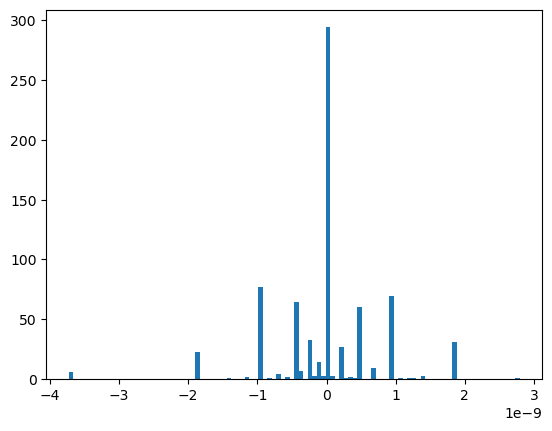

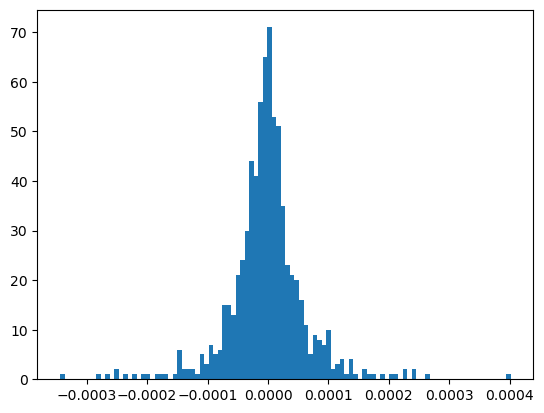

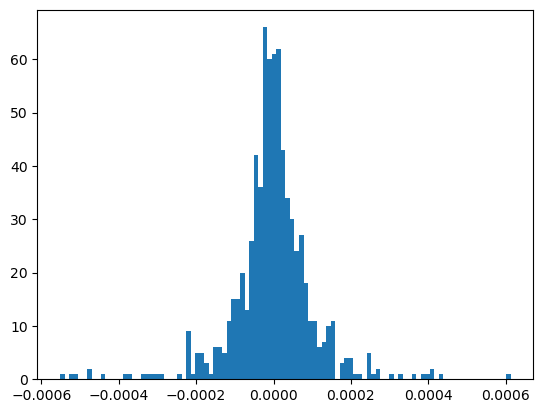

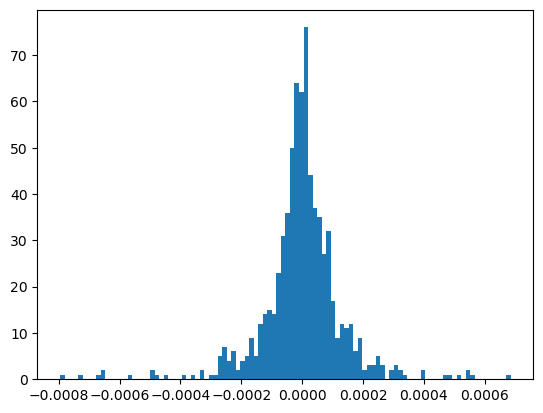

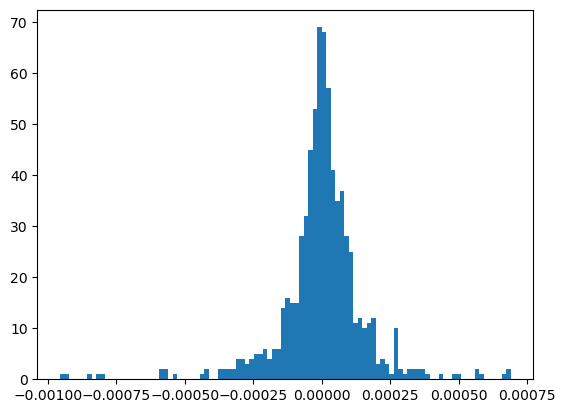

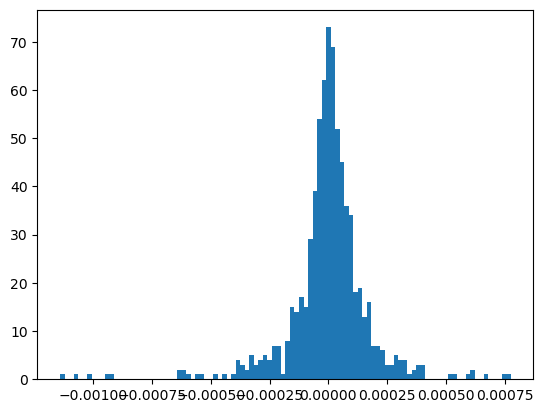

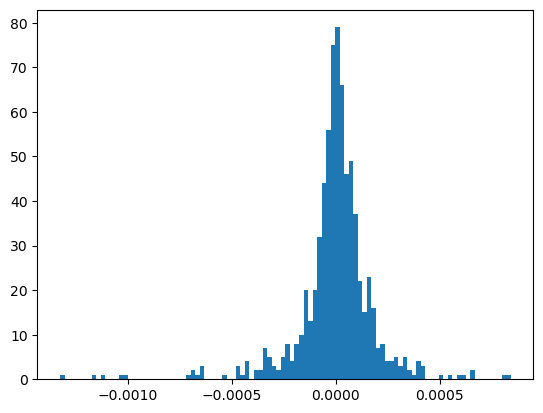

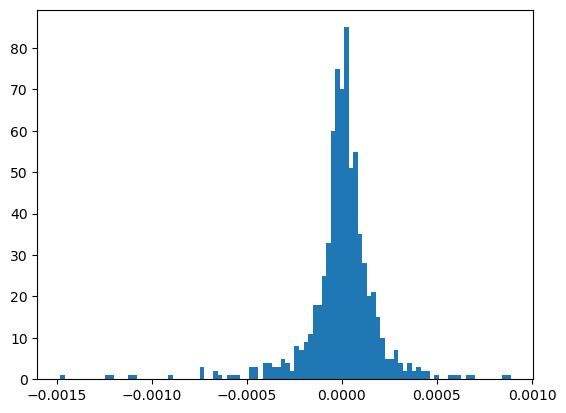

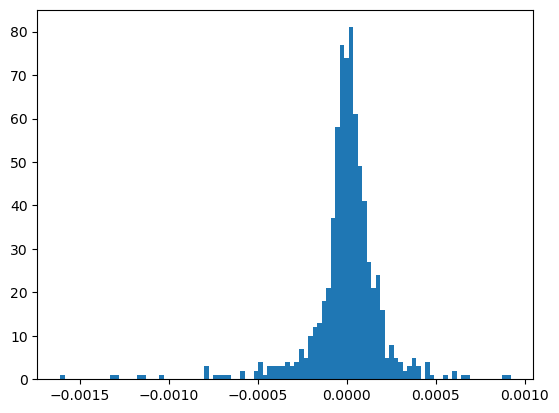

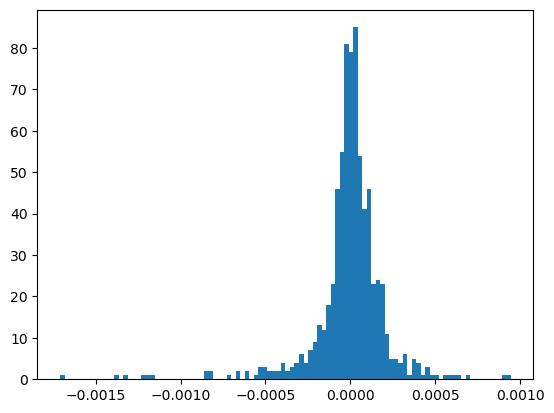

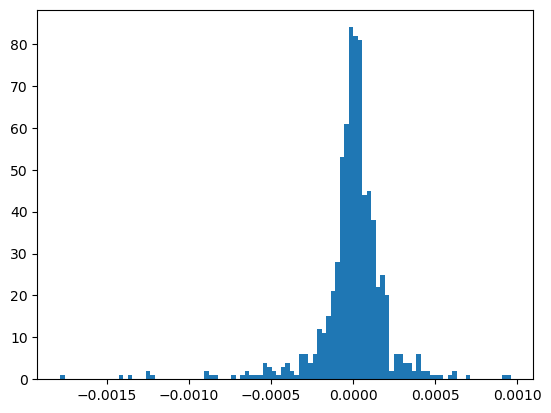

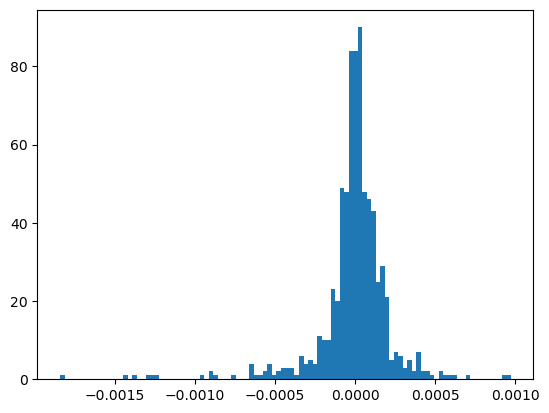

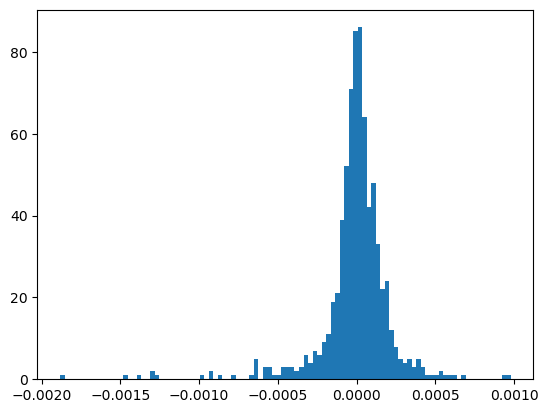

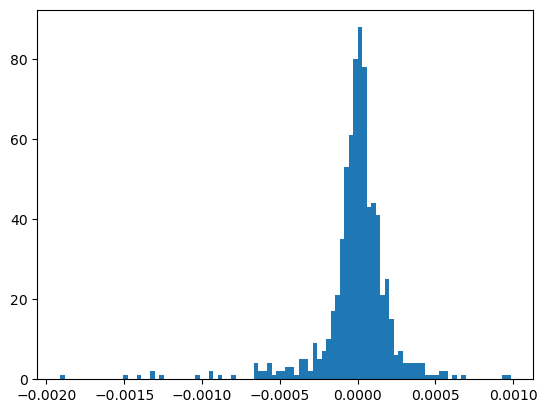

In [15]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

model = ensemble[0]
with torch.no_grad():
    X_t = X[ready]
    X_t = X_t.to(device)
    # norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
    norms = X_t.mean(dim=tuple(range(2, X_t.dim())))
    plt.figure()
    plt.hist(norms.cpu().numpy(), bins=100)
    # print(x.max())
    traj = [X_t]
    for t in range(nt-1):
        # if t%15 == 0:
        if False:
            x = evolve(x, cfg).to(device)
        else:
            # prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
            X_t = split_model(model, 256)(X_t)
            # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
        # norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        norms = X_t.mean(dim=tuple(range(2, X_t.dim())))
        plt.figure()
        plt.hist(norms.cpu().numpy(), bins=100)
        # print(x.max())
        traj.append(X_t)
    
traj_single = torch.stack(traj, dim=1)


In [16]:
real_traj = Y[256:][ready, :traj_single.shape[1]]
print(traj_single.shape, real_traj.shape)
assert real_traj.shape == traj_single.shape

print('Computing metrics...')
metrics = compute_metrics(real_traj.flatten(1), traj_single.flatten(1), d=2)
print(metrics[0].mean())
print(metrics[1].mean())
print(metrics[2].mean())

torch.Size([744, 14, 1, 256]) torch.Size([744, 14, 1, 256])
Computing metrics...
tensor(9.5108e-06, device='cuda:0')
tensor(0.0127, device='cuda:0')
tensor(0.0026, device='cuda:0')
